# Plot syllable waveforms

In [1]:
import toml
import numba
import joblib
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from toolz import partial
from tqdm.auto import tqdm
from scipy import stats, signal
from rl_analysis import ANALYSIS_CONFIG
from tqdm.contrib.concurrent import process_map
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import setup_plotting_env, save_factory, fg

warnings.simplefilter('ignore')
numba.set_num_threads(7)

## Loading and setup

In [2]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [3]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [4]:
setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'fig-01'), tight_layout=False)

In [6]:
# use prev sorting for comparison
sorting = joblib.load("/home/wg41/reinforcement_data/dlight_photometry/fig1-syllable-sorting.p")

In [7]:
use_dct = dlight_exclude_toml(
    "/home/wg41/reinforcement_data/_proc_photometry_dlight/dlight_photometry_processed_full.toml",
    **config["dlight_common"]
)

df = pd.read_parquet(
    config['intermediate_results']['dlight_public'],
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df["session_number"].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df["offline onset"] = False
df.loc[df.index[syll_onset(df["predicted_syllable (offline)"])], "offline onset"] = True

df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [8]:
time_window = (-1.5, 1.5)

In [11]:
def compute_waveforms(df, dlight_key, shuffle=False, syll_key="predicted_syllable (offline)"):
    out = {}
    for syll in sorting:
        inds = np.where(df["offline onset"] & (df[syll_key] == syll))[0]
        if shuffle:
            inds = inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds)))))
        time, trials = window_trials_as_mtx(
            df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
        )
        out[syll] = pd.Series(np.nanmean(trials, axis=0), index=pd.Index(time, name="time"))
    return pd.DataFrame(out)


def compute_shuffle(i, df):
    df = df.copy()
    result = compute_waveforms(df, dlight_key, shuffle=True)
    return result

## Panel - onset aligned syllable waveforms

In [22]:
dlight_key = "dlight filtered"
syll_key = "predicted_syllable (offline)"
waveforms = compute_waveforms(df, dlight_key)

### Z-scored re: shuffle version

In [17]:
n_shuffles = 1_000

results = process_map(
    partial(compute_shuffle, df=df[[syll_key, dlight_key, "offline onset"]]),
    range(n_shuffles),
    max_workers=7,
)

# SAVE SHUFFLES
joblib.dump(
    results,
    "/home/wg41/reinforcement_data/processed-dfs/fig1-filtered-waveform-shuffles-de-phasing.p",
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/home/wg41/reinforcement_data/processed-dfs/fig1-filtered-waveform-shuffles-de-phasing.p']

In [ ]:
# comment out if you want to run the shuffles yourself
# results = joblib.load(
#     "/home/wg41/reinforcement_data/processed-dfs/fig1-filtered-waveform-shuffles-de-phasing.p"
# )

In [20]:
shuff_waveforms = {k: pd.DataFrame([r[k] for r in results]) for k in sorting}

z_waveforms = {}
for k in sorting:
    v = waveforms[k]
    shuff = shuff_waveforms[k]
    z_waveforms[k] = (v - shuff.mean()) / shuff.std()

z_avg_waveforms = np.array(list(z_waveforms.values()))

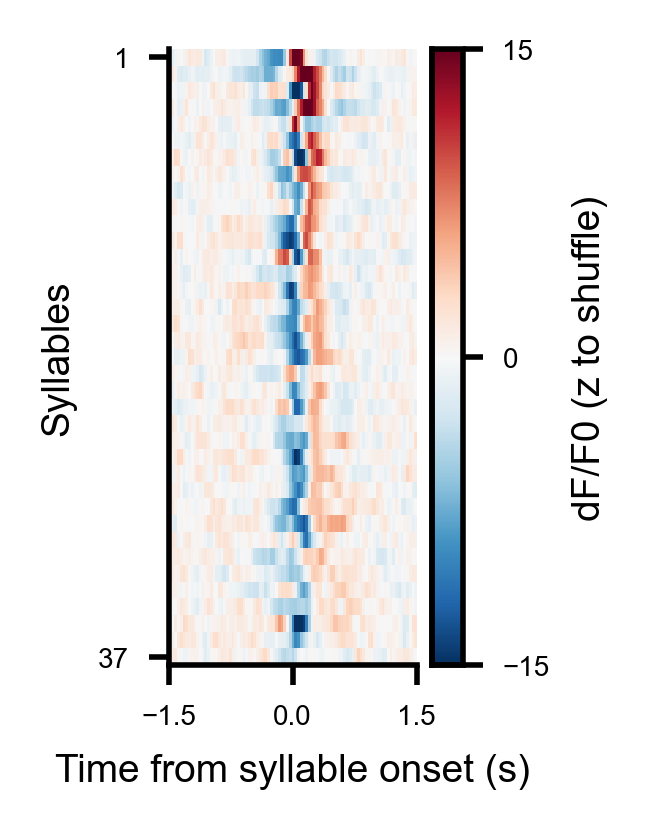

In [27]:
lims = 15
fig = fg(1, 2)
fig.dpi = 200
plt.imshow(
    z_avg_waveforms,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-lims,
    vmax=lims,
    interpolation='none',
    extent=(v.index[0], v.index[-1], len(z_avg_waveforms), 0),
)
cb = plt.colorbar()
cb.set_ticks([-lims, 0, lims])
cb.set_label('dF/F0 (z to shuffle)')
plt.xticks([time_window[0], 0, time_window[-1]])
plt.yticks([0.5, len(z_avg_waveforms) - 0.5], [1, len(z_avg_waveforms)])
plt.ylabel('Syllables')
plt.xlabel('Time from syllable onset (s)')
plt.xlim(*time_window)

sns.despine()
saver(fig, 'syllable-aligned-filtered-dlight-waveforms-z-re-shuffle');

In [24]:
kruskal_waveforms = {}

gb = df.groupby("mouse_id", observed=True, sort=False)

for syll in tqdm(sorting):
    mouse_waveforms = []
    for mouse, _df in gb:
        inds = np.where(_df["offline onset"] & (_df[syll_key] == syll))[0]
        time, mtx = window_trials_as_mtx(
            _df, inds, dlight_key, truncation_window=(0, 0.3), zscore_signal=True
        )
        mouse_waveforms.append(np.nanmean(mtx, axis=0))
    kruskal_waveforms[syll] = np.array(mouse_waveforms)

  0%|          | 0/37 [00:00<?, ?it/s]

In [25]:
stats.kruskal(*[x.mean(1) for x in kruskal_waveforms.values()])

KruskalResult(statistic=209.2901300498329, pvalue=2.590790009107372e-26)

In [26]:
stats.kruskal(*[x.max(1) for x in kruskal_waveforms.values()])

KruskalResult(statistic=193.0876616855146, pvalue=2.206896675740649e-23)